# Testing emcee stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [2]:
r = np.linspace(0.1, 3, 300)
true_profile = 2.3 * (r)**(-0.2)

In [3]:
i_zero = 1.0
gam = 0.8
fake_profile = i_zero * (r)**(-gam)

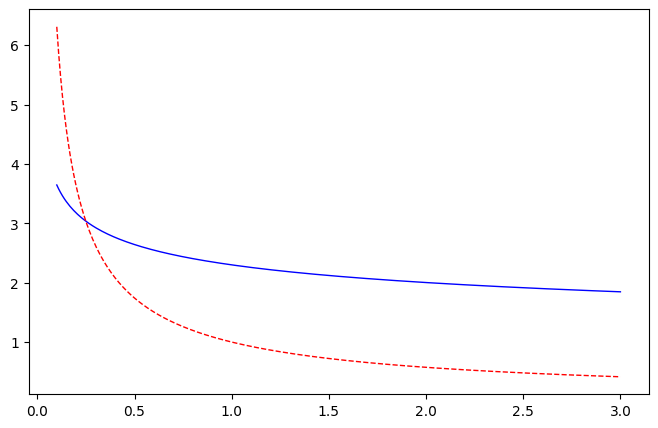

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(r, true_profile, label='True Profile', color='blue', linewidth=1)
plt.plot(r, fake_profile, label='Fake Profile', color='red', linestyle='--', linewidth=1)

100%|██████████| 3000/3000 [00:01<00:00, 2016.24it/s]


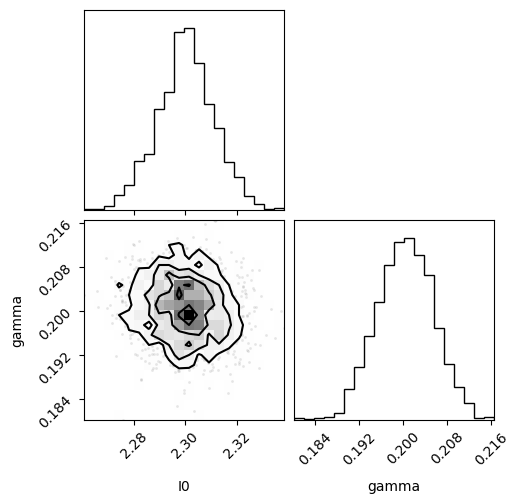

[2.30016756 0.20046932]


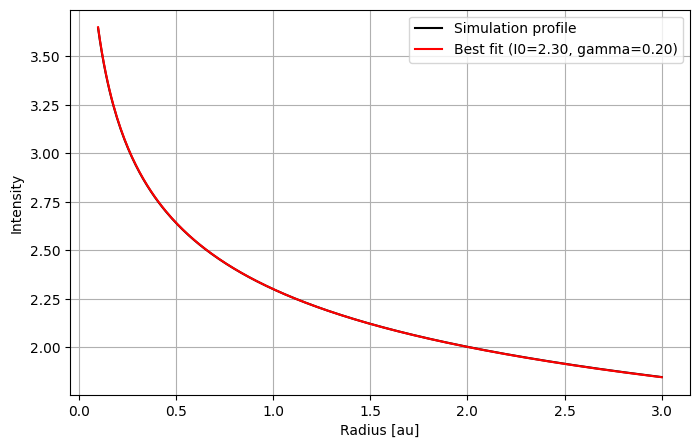

In [5]:
def model_powerlaw(r, i_zero, gamma):
    return i_zero * (r) ** (- gamma)


def log_prior(param):
    i_zero, gamma = param
    if 0. < i_zero < 10. and 0. < gamma < 5.:
        return 0.0
    return -np.inf


def log_likelihood(param, r, data, uncertanty):
    i_zero, gamma = param
    model = model_powerlaw(r, i_zero, gamma)
    return - 0.5 * np.sum(((data - model) / uncertanty) ** 2)


def log_probability(param, r, data, uncertanty):
    lp = log_prior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(param, r, data, uncertanty)


# Here I am defining errors as 5% of the max intensity value
uncertanty = np.full_like(true_profile, 0.05 * np.max(true_profile))

# Setting up initial guess
initial = np.array([1.0, 1.0])
ndim = len(initial)
nwalkers = 10
initial_pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r, true_profile, uncertanty))
sampler.run_mcmc(initial_pos, 3000, progress=True)

flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

corner.corner(flat_samples, labels=["I0", "gamma"], truths=[None, None])
plt.show()

best_params = np.median(flat_samples, axis=0)
best_model = model_powerlaw(r, *best_params)
print(best_params)
plt.figure(figsize=(8, 5))
plt.plot(r, true_profile, label="Simulation profile", color="black")
plt.plot(r, best_model, label=f"Best fit (I0={best_params[0]:.2f}, gamma={best_params[1]:.2f})", color="red")
plt.xlabel("Radius [au]")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True)
plt.show()
